# Image classification

In [1]:
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import cv2
import io
import random
import imageio.v3 as iio
from scipy.ndimage import rotate
from skimage import img_as_ubyte
from skimage.io import imread

import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import imageio.v3 as iio

from sklearn.model_selection import train_test_split


# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Softmax
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
intel_train = '/kaggle/input/intel-image-classification/seg_train/seg_train'
intel_test = '/kaggle/input/intel-image-classification/seg_test/seg_test'
all_intel_dir = '/kaggle/working/all_intel'

In [3]:
intel_class = [d for d in os.listdir(intel_train) if os.path.isdir(os.path.join(intel_train, d))]

In [4]:
intel_class

['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']

In [5]:
for intel in intel_class:
    shutil.copytree(os.path.join(intel_train, intel), os.path.join('all_intel', intel), dirs_exist_ok=True)
    shutil.copytree(os.path.join(intel_test, intel), os.path.join('all_intel', intel), dirs_exist_ok=True)

In [6]:
file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(all_intel_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_intel = pd.DataFrame({'path':full_path, 'file_name':file_name, 'labels':labels})

In [7]:
distribution_intel

,path,file_name,labels
0,/kaggle/working/all_intel/forest/19142.jpg,19142.jpg,forest
1,/kaggle/working/all_intel/forest/10909.jpg,10909.jpg,forest
2,/kaggle/working/all_intel/forest/6196.jpg,6196.jpg,forest
3,/kaggle/working/all_intel/forest/12125.jpg,12125.jpg,forest
4,/kaggle/working/all_intel/forest/23873.jpg,23873.jpg,forest
...,...,...,...
17029,/kaggle/working/all_intel/buildings/8525.jpg,8525.jpg,buildings
17030,/kaggle/working/all_intel/buildings/14261.jpg,14261.jpg,buildings
17031,/kaggle/working/all_intel/buildings/18415.jpg,18415.jpg,buildings
17032,/kaggle/working/all_intel/buildings/7570.jpg,7570.jpg,buildings


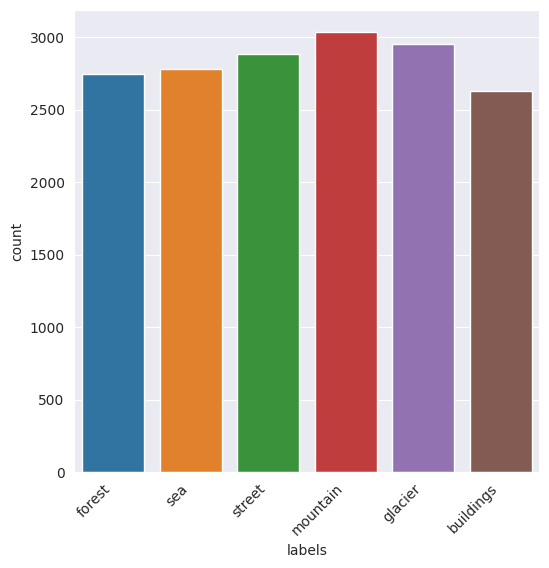

In [8]:
plt.figure(figsize = (6,6))
sns.set_style('darkgrid')
plot_data = sns.countplot(x='labels', data=distribution_intel)
plt.xticks(rotation=45, ha='right')
plt.show()

In [9]:
labels_num = pd.DataFrame(distribution_intel.groupby(by=['labels']).size().reset_index(name='count'))

In [10]:
labels_num['add'] = 3100 - labels_num['count']

In [11]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)
 
# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)
 
# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)
 
# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img
 
# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)
 
# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image
 
# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [12]:
transformations = {'rotate anticlockwise': anticlockwise_rotation,
                  'rotate clockwise': clockwise_rotation,
                  'warp shift': warp_shift,
                   'blurring image':blur_image,
                   'add brightness': add_brightness,
                   'flip up down': flip_up_down,
                   'shear image': sheared
                  }
def augmentation(intel_name, num_aug):
    images_path =os.path.join(all_intel_dir, intel_name)
    
    images=[]
    
    for im in os.listdir(images_path):
        images.append(os.path.join(images_path, im))
    
    images_to_generate = num_aug
    i=1
    
    while i<=images_to_generate:
        image=random.choice(images)
        try:
            original_image =iio.imread(image)
            transformed_image=None
            n = 0
            transformation_count = random.randint(1, len(transformations))
            while n <= transformation_count:
                key = random.choice(list(transformations))
                transformed_image = transformations[key](original_image)
                n = n + 1
                #new_image_path = '%s/augmented_image_%s.jpg' %(images_path, i)
                new_image_path = f"{images_path}/augmented_image_{i}.jpg"
                transformed_image = img_as_ubyte(transformed_image)
                cv2.imwrite(new_image_path, transformed_image)
                i = i + 1
        except ValueError as e:
            print('could not read the',image ,':',e,'hence skipping it.')

In [13]:
labels_num

,labels,count,add
0,buildings,2628,472
1,forest,2745,355
2,glacier,2957,143
3,mountain,3037,63
4,sea,2784,316
5,street,2883,217


In [14]:
for _, row in labels_num.iterrows():
    label = row['labels']
    add = row['add']
    augmentation(label, add)

In [15]:
augmentation('glacier', 250)
augmentation('mountain', 100)

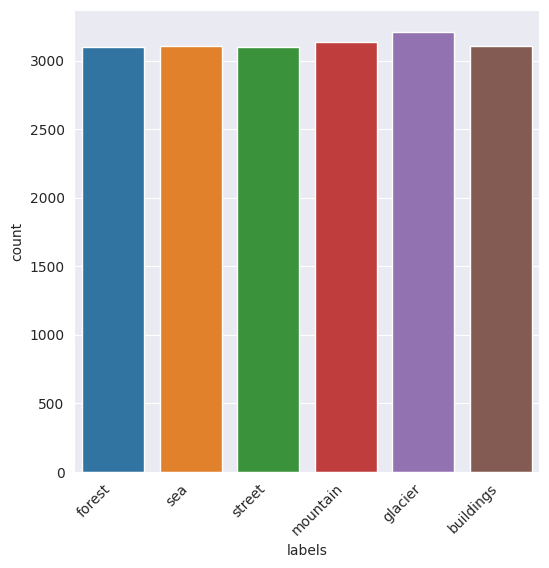

In [16]:
file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(all_intel_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_intel = pd.DataFrame({'path':full_path, 'file_name':file_name, 'labels':labels})

plt.figure(figsize = (6,6))
sns.set_style('darkgrid')
plot_data = sns.countplot(x='labels', data=distribution_intel)
plt.xticks(rotation=45, ha='right')
plt.show()

In [17]:
x = distribution_intel['path']
y = distribution_intel['labels']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100)
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9, random_state=100)
#xx_train, xx_test, yy_train, yy_test = train_test_split(x_train, y_train, test_size=0.2, random_state=101)

In [18]:
df_train = pd.DataFrame({'path':x_train, 'labels':y_train, 'set':'train'})
df_test = pd.DataFrame({'path':x_test, 'labels':y_test, 'set':'test'})

In [19]:
df_all = pd.concat([df_train, df_test], ignore_index=True)
print('=====')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===== \n')
print(df_all.sample(5))

=====
set    labels   
test   buildings     627
       forest        656
       glacier       601
       mountain      609
       sea           599
       street        660
train  buildings    2477
       forest       2445
       glacier      2608
       mountain     2530
       sea          2505
       street       2443
dtype: int64 

===== 

                                                    path     labels    set
13029         /kaggle/working/all_intel/forest/23242.jpg     forest  train
1663           /kaggle/working/all_intel/street/1572.jpg     street  train
8840        /kaggle/working/all_intel/mountain/22250.jpg   mountain  train
17466  /kaggle/working/all_intel/forest/augmented_ima...     forest   test
13283  /kaggle/working/all_intel/buildings/augmented_...  buildings  train


In [20]:
datasource_path = all_intel_dir
dataset_path = 'Dataset-Final'

In [21]:
for index, row in tq(df_all.iterrows()):
    file_path = row['path']
    if os.path.exists(file_path) == False:
        file_path = os.path.join(datasource_path, row['labels'], row['image'].split('.')[0])

    if os.path.exists(os.path.join(dataset_path, row['set'], row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path, row['set'], row['labels']))

    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path, row['set'], row['labels'], destination_file_name)

    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path, file_dest)

0it [00:00, ?it/s]

In [22]:
TRAIN_DIR = '/kaggle/working/Dataset-Final/train'
TEST_DIR = '/kaggle/working/Dataset-Final/test'

In [23]:
datagen = ImageDataGenerator(rescale=1/255.,
                            validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                             batch_size=32,
                                             target_size=(150, 150),
                                              color_mode='grayscale',
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                  batch_size=32,
                                                  target_size=(150, 150),
                                                  color_mode='grayscale',
                                                  class_mode='categorical',
                                                  subset='validation',
                                                  shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                 batch_size=1,
                                                 target_size=(150, 150),
                                                 color_mode='grayscale',
                                                 class_mode='categorical',
                                                 shuffle=False)

Found 12008 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 3752 images belonging to 6 classes.


In [24]:
model_1 = None


model_1 = Sequential()

model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2,2)))

model_1.add(Conv2D(64, (4, 4), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

model_1.add(Conv2D(128, (7,7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

model_1.add(Conv2D(256, (7,7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

model_1.add(Conv2D(512, (7,7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

model_1.add(Flatten())
model_1.add(Dense(512, activation = 'relu'))
model_1.add(Dropout(0.25))
model_1.add(Dense(256, activation = 'relu'))
model_1.add(Dropout(0.25))
model_1.add(Dense(64, activation = 'relu'))
model_1.add(Dropout(0.25))


model_1.add(Dense(6, activation='softmax'))

model_1.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

print(model_1.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │       1,605,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 18, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 9, 9, 512)           │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 9, 9, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,3

 Total params: 12,810,566 (48.87 MB)

 Trainable params: 12,808,582 (48.86 MB)

 Non-trainable params: 1,984 (7.75 KB)

None


In [25]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.95):
      print("\nVal Akurasi telah mencapai >95%!")
      self.model.stop_training = True
callbacks = myCallback()

In [26]:
history_1 = model_1.fit(train_generator,
                       epochs=25,
                        callbacks=[callbacks],
                       batch_size=32,
                       validation_data=validation_generator,)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


376/376 ━━━━━━━━━━━━━━━━━━━━ 1573s 4s/step - accuracy: 0.3675 - loss: 2.0057 - val_accuracy: 0.2880 - val_loss: 2.3987
Epoch 2/25
376/376 ━━━━━━━━━━━━━━━━━━━━ 1590s 4s/step - accuracy: 0.6148 - loss: 1.0508 - val_accuracy: 0.5347 - val_loss: 1.2871
Epoch 3/25
376/376 ━━━━━━━━━━━━━━━━━━━━ 1568s 4s/step - accuracy: 0.6796 - loss: 0.8856 - val_accuracy: 0.7400 - val_loss: 0.6961
Epoch 4/25
376/376 ━━━━━━━━━━━━━━━━━━━━ 1634s 4s/step - accuracy: 0.7242 - loss: 0.7537 - val_accuracy: 0.6680 - val_loss: 0.9918
Epoch 5/25
376/376 ━━━━━━━━━━━━━━━━━━━━ 1567s 4s/step - accuracy: 0.7581 - loss: 0.7121 - val_accuracy: 0.6997 - val_loss: 0.9072
Epoch 6/25
376/376 ━━━━━━━━━━━━━━━━━━━━ 1560s 4s/step - accuracy: 0.7880 - loss: 0.6138 - val_accuracy: 0.6720 - val_loss: 1.0032
Epoch 7/25
376/376 ━━━━━━━━━━━━━━━━━━━━ 1571s 4s/step - accuracy: 0.8102 - loss: 0.5584 - val_accuracy: 0.7960 - val_loss: 0.5902
Epoch 8/25
376/376 ━━━━━━━━━━━━━━━━━━━━ 1634s 4s/step - accuracy: 0.8347 - loss: 0.4804 - val_accurac

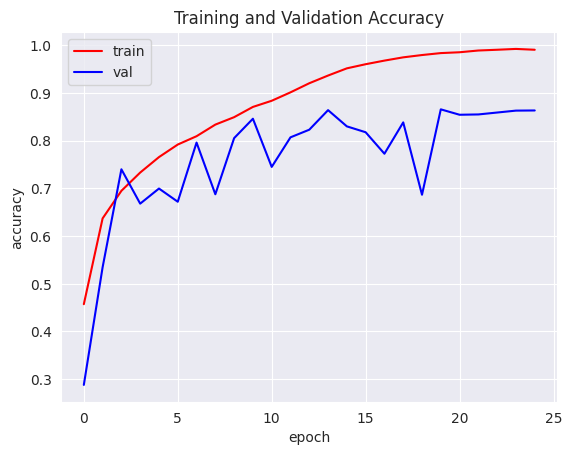

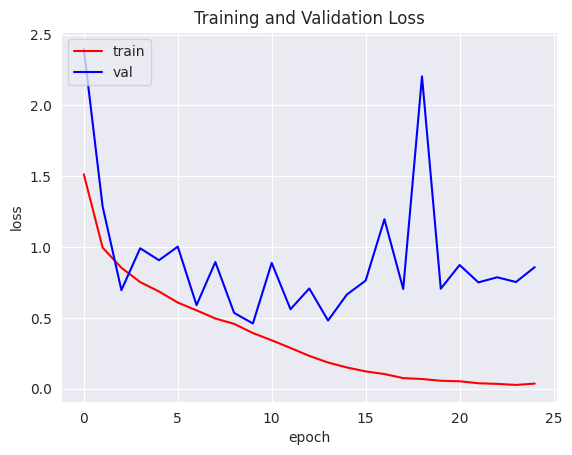

In [27]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

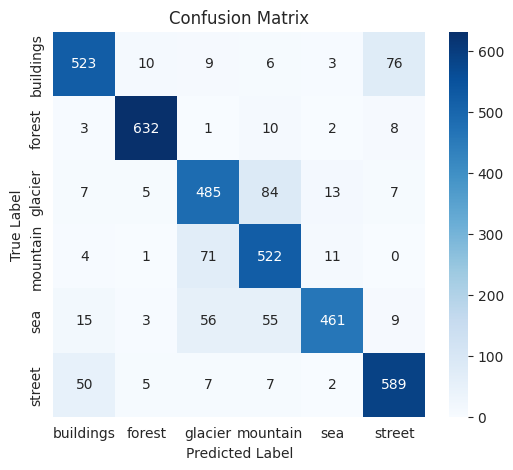


Classification Report:

              precision    recall  f1-score   support

           0     0.8688    0.8341    0.8511       627
           1     0.9634    0.9634    0.9634       656
           2     0.7711    0.8070    0.7886       601
           3     0.7632    0.8571    0.8074       609
           4     0.9370    0.7696    0.8451       599
           5     0.8549    0.8924    0.8732       660

    accuracy                         0.8561      3752
   macro avg     0.8597    0.8540    0.8548      3752
weighted avg     0.8610    0.8561    0.8566      3752



In [28]:

test_generator.reset()
preds_1 = model_1.predict(test_generator, verbose=0)

if preds_1.shape[1] > 1: 
    y_pred = np.argmax(preds_1, axis=1)
else: 
    y_pred = (preds_1 > 0.5).astype(int).flatten()

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=test_generator.class_indices.keys(), columns=test_generator.class_indices.keys())

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, digits=4))

In [29]:
tf.saved_model.save(model_1, '/kaggle/working/saved-model')

In [30]:
model_1.save('model.h5')
!pip install tensorflowjs
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.25.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
plotnine 0.14.4 requires matplotlib>

In [31]:
model = tf.keras.models.load_model('/kaggle/working/model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model-tflite.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpw2t31stx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  138040298311872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138040384634048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138040537776368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138040384212304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138040384626128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138040384633168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138040384214592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138040384213712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138040384218992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138040384224096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138040384223744

In [32]:
#shutil.rmtree('/kaggle/working/all_intel')
#shutil.rmtree('/kaggle/working/Dataset-Final')

In [33]:
pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.2.1
aiofiles==22.1.0
aiohappyeyeballs==2.4.6
aiohttp==3.11.12
aiosignal==1.3.2
aiosqlite==0.21.0
alabaster==1.0.0
albucore==0.0.19
albumentations==1.4.20
alembic==1.14.1
altair==5.5.0
annotated-types==0.7.0
annoy==1.17.3
ansicolors==1.1.8
antlr4-python3-runtime==4.9.3
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
args==0.1.0
array_record==0.5.1
arrow==1.3.0
arviz==0.20.0
astropy==6.1.7
astropy-iers-data==0.2024.12.16.0.35.48
asttokens==3.0.0
astunparse==1.6.3
async-timeout==5.0.1
atpublic==4.1.0
attrs==25.1.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
bayesian-optimization==2.0.3
beautifulsoup4==4.12.3
betterproto==2.0.0b6
bigframes==1.29.0
bigquery-magics==0.4.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blobfile==3.0.0
blosc2==2.7.1
bokeh==3.6.2
Boruta==0.4.3
boto3==1.36.23
botocore==1.36.23
Bottleneck==1.4.2
-e git+https://github.com/SohierDane/BigQuery_Helper@8615a7f6c1663e7f2d48aa2b32c2dbcb600a440f#egg=bq_helper
bqplo

# Inference

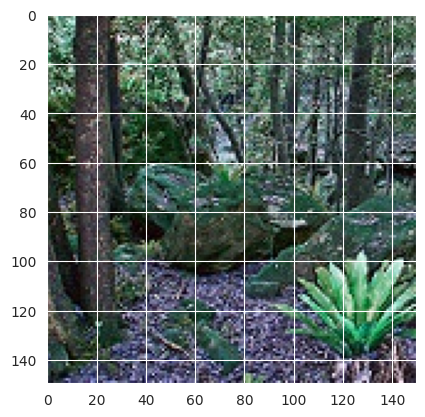

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
      labels   Possibility
0  buildings  0.000000e+00
1     forest  1.000000e+00
2    glacier  0.000000e+00
3   mountain  0.000000e+00
4        sea  0.000000e+00
5     street  3.135750e-37


In [34]:
model_inference = tf.keras.models.load_model('/kaggle/working/model.h5')

image_path = '/kaggle/input/intel-image-classification/seg_pred/seg_pred/10092.jpg'
image = cv2.imread(image_path)
plt.imshow(image)
plt.show()

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (150, 150))
image = image / 255.0
image = np.expand_dims(image, axis=0)
image = np.expand_dims(image, axis=-1)
prediction = model_inference.predict(image)
x = pd.DataFrame({'Possibility': prediction.reshape(-1)})
y = pd.concat([labels_num['labels'], x], axis=1)
print(y)